In [1]:
import requests
import pandas as pd
import xml.etree.ElementTree as ET
import os
import cv2
import torch
import torch.nn as nn
import torchvision
from torchvision import models
from torchvision.models import resnet50, ResNet50_Weights

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.image import imread
from PIL import Image
from concurrent.futures import ThreadPoolExecutor, as_completed
import csv
base_dir = os.getcwd()

In [36]:
model = models.inception_v3(pretrained=True, aux_logits=True)
model.eval()


def preprocess_image(image_path):
    """
    Preprocesses a single image for InceptionV3 input.
    """
    # Read the image as grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Resize to 299x299 for InceptionV3
    img = cv2.resize(img, (299, 299))
    
    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img = clahe.apply(img)
    
    # Normalize to [0, 1]
    img = np.array(img, dtype=np.float32) / 255.0
    
    # Since the model expects 3 channels, we stack the grayscale image to create 3 channels
    img = np.stack([img, img, img], axis=-1)
    
    # Apply Gamma correction
    gamma = 1.2  # Example gamma value, adjust as necessary
    img = np.power(img, gamma)
    
    # Normalize with ImageNet mean and std
    img = (img - np.array([0.485, 0.456, 0.406])) / np.array([0.229, 0.224, 0.225])
    
    # Transpose to (channels, height, width)
    img = np.transpose(img, (2, 0, 1))
    
    # Add batch dimension
    img = np.expand_dims(img, axis=0)
    
    # Convert to PyTorch tensor with dtype float32
    img = torch.tensor(img, dtype=torch.float32)

    return img

def extract_features(image_path):
    """
    Extract features from a single image using InceptionV3.
    """
    img = preprocess_image(image_path)
    with torch.no_grad():
        features = model(img)
    return features.squeeze(0).numpy()

def normalize_features(features):
    """
    Normalize the extracted features.
    """
    return features / np.linalg.norm(features)

def compute_similarity(nk_img_feature_descriptor, munich_img_path):
    """
    Computes the similarity between two images
    """
    if not os.path.exists(munich_img_path):
        raise FileNotFoundError(f"Munich image file {munich_img_path} not found.")
    
    munich_img_feature_descriptor = normalize_features(extract_features(munich_img_path).flatten())
    similarity = np.dot(nk_img_feature_descriptor, munich_img_feature_descriptor)
    return similarity.item()

def compute_similarities_img_to_set(nk_img, munich_testset, munich_path="mc_no_back", nk_path="nk_no_back", max_workers=6):
    """
    Computes the similarity of 1 (NK) image with an entire set of images (MCCP)
    """
    similarities = {}
    counter = 0
    nk_img_path = os.path.join(nk_path, nk_img)
    
    # Ensure the NK image file exists
    if not os.path.exists(nk_img_path):
        raise FileNotFoundError(f"NK image file {nk_img_path} not found.")
    
    nk_img_feature_descriptor = normalize_features(extract_features(nk_img_path).flatten())
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_munich_img = {executor.submit(compute_similarity, nk_img_feature_descriptor, os.path.join(munich_path, munich_img)): munich_img for munich_img in munich_testset}
        
        for future in as_completed(future_to_munich_img):
            munich_img = future_to_munich_img[future]
            try:
                similarity = future.result()
                similarities[(nk_img, munich_img)] = similarity
            except Exception as exc:
                print(f"Munich image {munich_img} generated an exception: {exc}")
            # print(f"Processed {counter} images")
    
    return similarities

In [3]:
# Code to assign classes to MCCP images
# The first run will take about 60 minutes, after that a file with classes is saved.

weights = ResNet50_Weights.DEFAULT
model_class = resnet50(weights=weights)
model_class.eval()

preprocess = weights.transforms()
labeled_list = [[]]

for file in os.listdir('scraped_images_grayscaled_big'):
    image = Image.open(os.path.join('scraped_images_grayscaled_big', file)).convert('RGB')
    batch = preprocess(image).unsqueeze(0)

    prediction = model_class(batch).squeeze(0).softmax(0)
    class_id = prediction.argmax().item()
    score = prediction[class_id].item()
    category_name = weights.meta["categories"][class_id]
    labeled_list += [file, category_name]

combined_list = []

# Iterate through the list starting from the second item, in steps of 2
for i in range(1, len(labeled_list) - 1, 2):
    combined_list.append([labeled_list[i], labeled_list[i + 1]])

# If the list length is odd, we need to handle the last item
if len(labeled_list) % 2 == 0:
    combined_list.append([labeled_list[-2], labeled_list[-1]])
else:
    combined_list.append([labeled_list[-3], labeled_list[-2]])

my_df = pd.DataFrame(combined_list)

my_df.to_csv('image_categories.csv', index=False, header=False)


In [4]:
def classify_image(img_name):
    image = Image.open(os.path.join('nk_collection_paintings_cleaned', img_name)).convert('RGB')

    # Step 1: Initialize model with the best available weights
    weights = ResNet50_Weights.DEFAULT
    model_class = resnet50(weights=weights)
    model_class.eval()

    # Step 2: Initialize the inference transforms
    preprocess = weights.transforms()

    # Step 3: Apply inference preprocessing transforms
    batch = preprocess(image).unsqueeze(0)

    # Step 4: Use the model and print the predicted category
    prediction = model_class(batch).squeeze(0).softmax(0)
    class_id = prediction.argmax().item()
    category_name = weights.meta["categories"][class_id]
    
    return category_name

In [39]:
# Insert NK image here
nk_img = ("schilderij_465.jpg")
nk_category = classify_image(nk_img)
print('class: ', nk_category)

munich_set = []

with open('image_categories.csv', newline='') as csvfile:

    img_reader = csv.reader(csvfile, delimiter=',', quotechar='|')

    for row in img_reader:
        if row[1] == nk_category:
            munich_set += [row[0]]

# Without image classifying uncomment the next line 
# munich_set = os.listdir("scraped_images_grayscaled_big")

print('class size:', len(munich_set))
print('running...')
# Insert path to images 'munich_path' and 'nk_path'
sims = compute_similarities_img_to_set(nk_img, munich_set, munich_path='scraped_images_grayscaled_big' ,nk_path='nk_collection_paintings_cleaned')
print('done')

class:  hoopskirt
class size: 571
running...
done


Ranking of images similar to NK image 'schilderij_465.jpg':


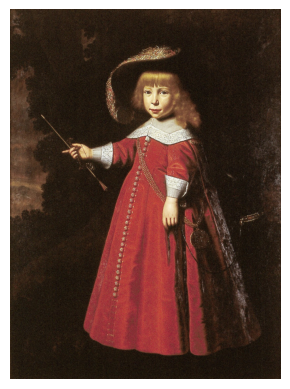

Rank 1: Munich image '0788_4943_id=cp132063_linz.jpg' (Similarity: 0.7873420119285583)


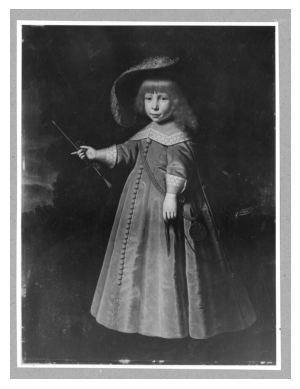

Rank 2: Munich image '0051_188-2_id=cp145826_badv.jpg' (Similarity: 0.7534817457199097)


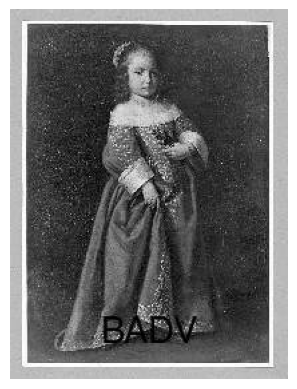

Rank 3: Munich image '1238_9558_id=cp130174_linz.jpg' (Similarity: 0.7086899876594543)


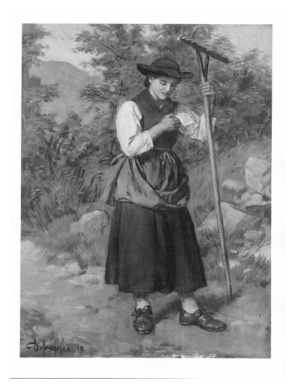

Rank 4: Munich image '0241_1306_id=cp139606_badv.jpg' (Similarity: 0.7078547477722168)


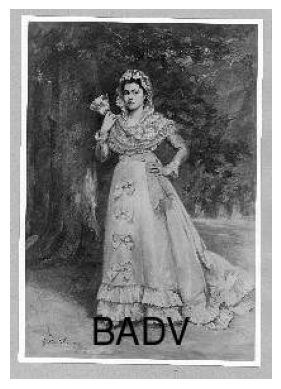

Rank 5: Munich image '0271_1458_id=cp131506_linz.jpg' (Similarity: 0.6618609428405762)


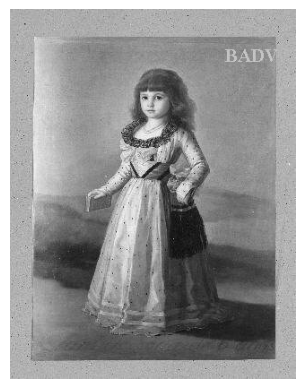

Rank 6: Munich image '0271_1458-1_id=cp141430_badv.jpg' (Similarity: 0.6137617826461792)


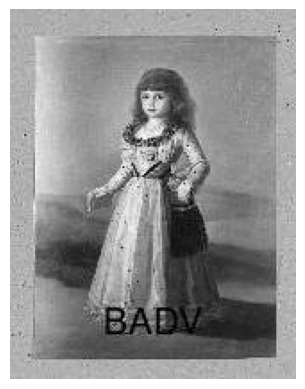

Rank 7: Munich image '0741_4486_id=cp163290_badv.jpg' (Similarity: 0.6007997989654541)


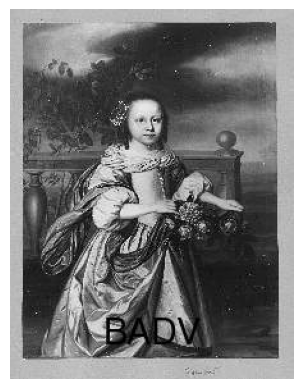

Rank 8: Munich image '0272_1470-1_id=cp141579_badv.jpg' (Similarity: 0.5964301228523254)


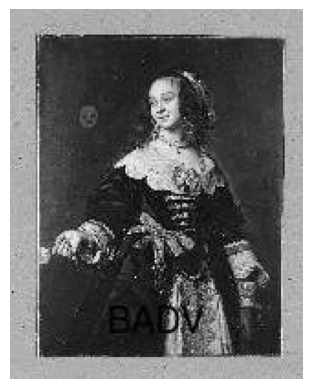

Rank 9: Munich image '2216_45070_id=cp163534_badv.jpg' (Similarity: 0.5950658917427063)


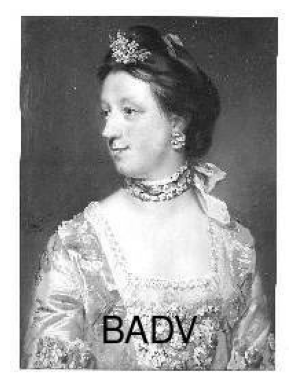

Rank 10: Munich image '1354_11220_id=cp133856_linz.jpg' (Similarity: 0.5950314402580261)


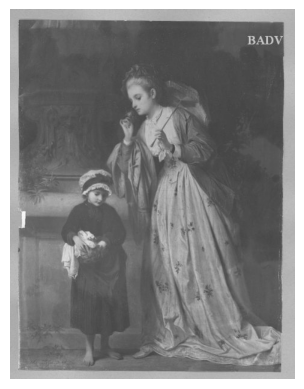

Rank 11: Munich image '1274_9903_id=cp177762_badv.jpg' (Similarity: 0.5900208950042725)


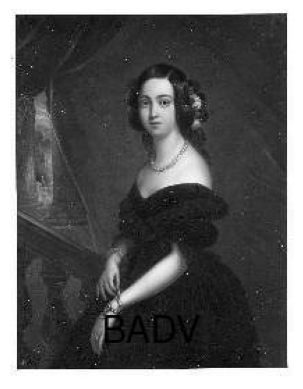

Rank 12: Munich image '0960_7198_id=cp171108_badv.jpg' (Similarity: 0.588228702545166)


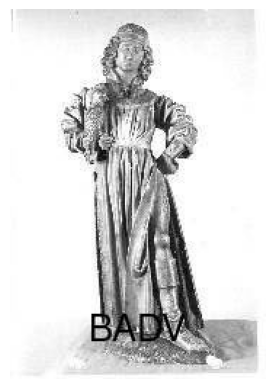

Rank 13: Munich image '0270_1455-3_id=cp141412_badv.jpg' (Similarity: 0.5843445062637329)


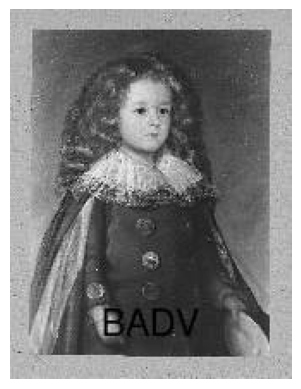

Rank 14: Munich image '0101_550-2_id=cp168653_badv.jpg' (Similarity: 0.5805543661117554)


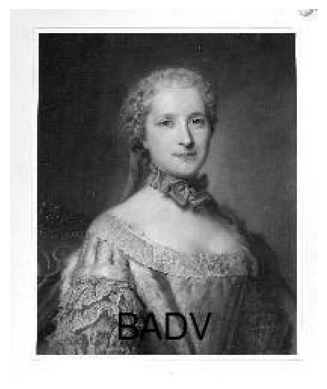

Rank 15: Munich image '0272_1468-2_id=cp141558_badv.jpg' (Similarity: 0.5804739594459534)


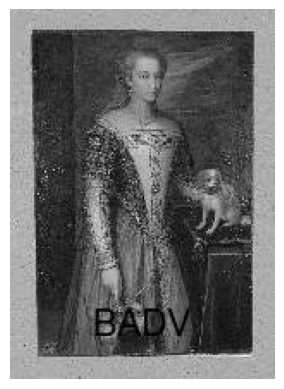

Rank 16: Munich image '0737_4457_id=cp132013_linz.jpg' (Similarity: 0.5749553442001343)


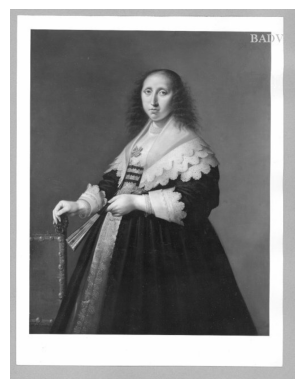

Rank 17: Munich image '1734_21838-10_id=cp147467_badv.jpg' (Similarity: 0.5712422728538513)


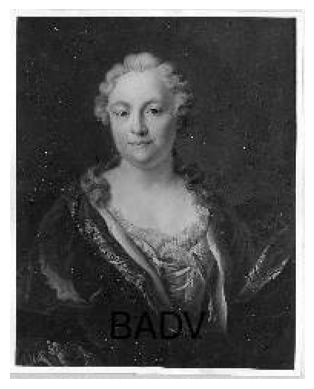

Rank 18: Munich image '1592_15862-5_id=cp143043_badv.jpg' (Similarity: 0.5604323148727417)


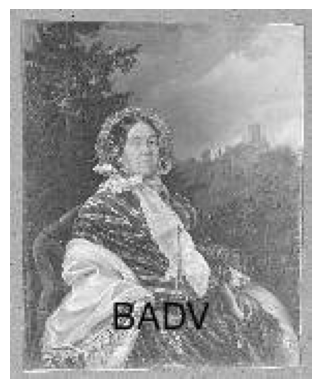

Rank 19: Munich image '1349_11168_id=cp132709_linz.jpg' (Similarity: 0.5585668683052063)


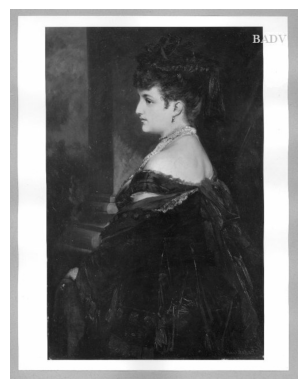

Rank 20: Munich image '0737_4457_id=cp162980_badv.jpg' (Similarity: 0.5564048290252686)


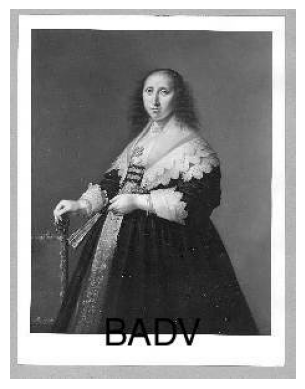

Rank 21: Munich image '1310_10562_id=cp135647_badv.jpg' (Similarity: 0.55158531665802)


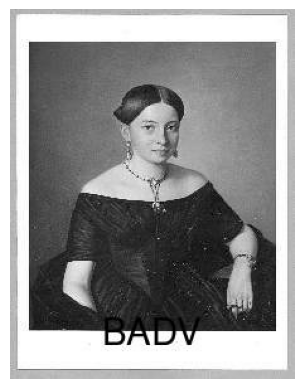

Rank 22: Munich image '0386_1727_id=cp144899_badv.jpg' (Similarity: 0.5482814908027649)


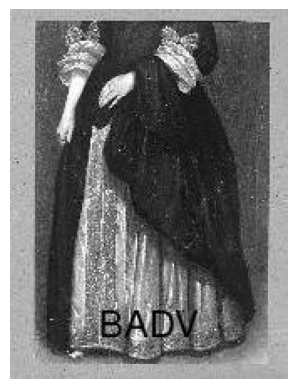

Rank 23: Munich image '1287_10077_id=cp130776_linz.jpg' (Similarity: 0.5456878542900085)


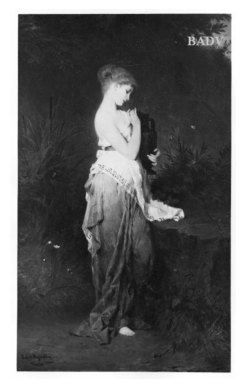

Rank 24: Munich image '1197_9141_id=cp130540_linz.jpg' (Similarity: 0.5454711318016052)


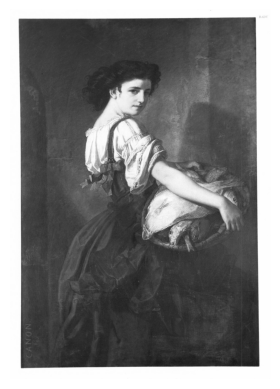

Rank 25: Munich image '1347_11145_id=cp136353_badv.jpg' (Similarity: 0.544822633266449)


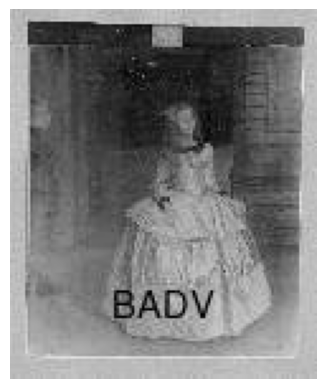

Rank 26: Munich image '1323_10754_id=cp133041_linz.jpg' (Similarity: 0.5443943738937378)


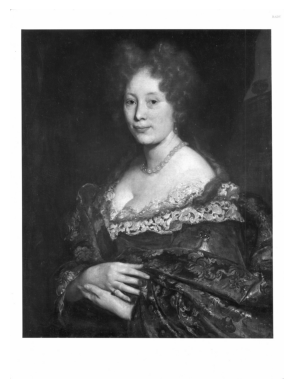

Rank 27: Munich image '0241_1305_id=cp139596_badv.jpg' (Similarity: 0.5433588027954102)


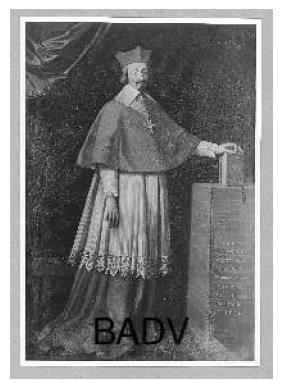

Rank 28: Munich image '1222_9394_id=cp176208_badv.jpg' (Similarity: 0.5383026003837585)


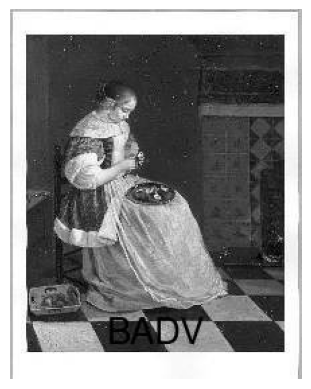

Rank 29: Munich image '0393_1782-3_id=cp145497_badv.jpg' (Similarity: 0.5376399755477905)


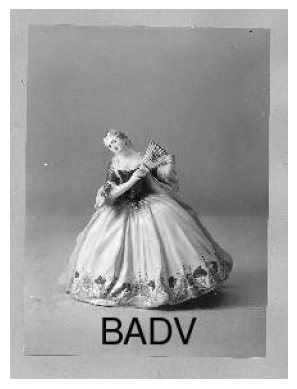

Rank 30: Munich image '0753_4590_id=cp133359_linz.jpg' (Similarity: 0.5373485088348389)


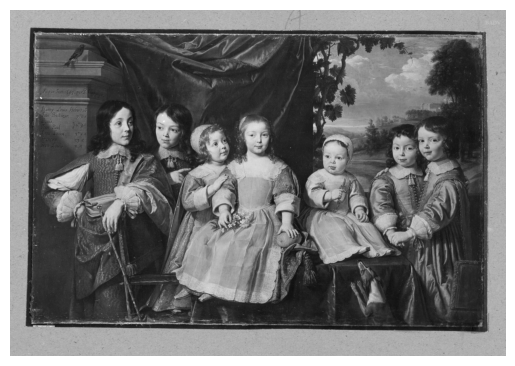

Rank 31: Munich image '0273_1470-1_id=cp131479_linz.jpg' (Similarity: 0.5309018492698669)


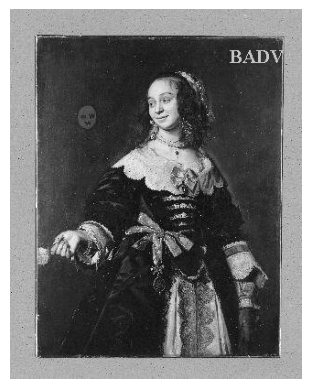

Rank 32: Munich image '0837_5319_id=cp168328_badv.jpg' (Similarity: 0.5283548831939697)


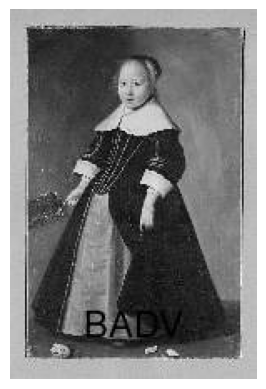

Rank 33: Munich image '1269_9835_id=cp177687_badv.jpg' (Similarity: 0.527427077293396)


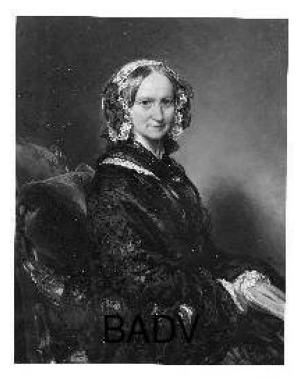

Rank 34: Munich image '0629_3644_id=cp157098_badv.jpg' (Similarity: 0.5208739042282104)


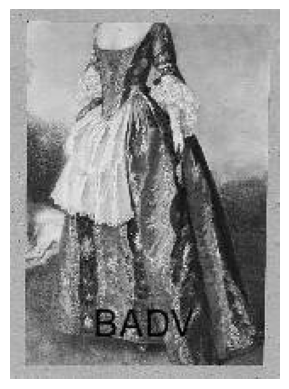

Rank 35: Munich image '1286_10077_id=cp135086_badv.jpg' (Similarity: 0.5177993774414062)


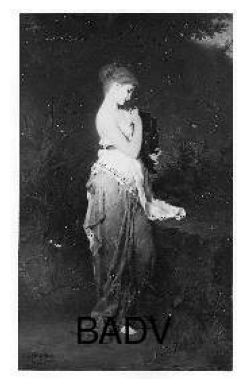

Rank 36: Munich image '1222_9394_id=cp132466_linz.jpg' (Similarity: 0.5135714411735535)


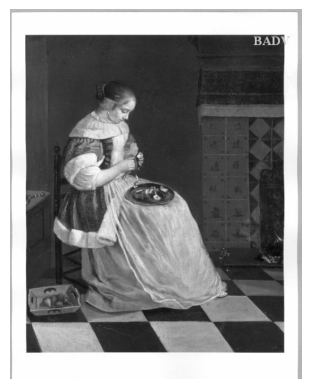

Rank 37: Munich image '1354_11220_id=cp136439_badv.jpg' (Similarity: 0.5123252868652344)


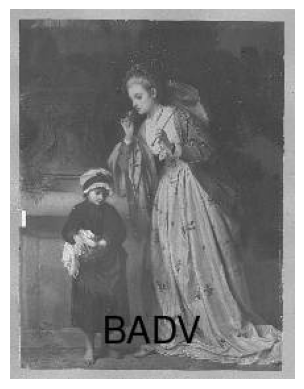

Rank 38: Munich image '0551_2621_id=cp131889_linz.jpg' (Similarity: 0.5111950039863586)


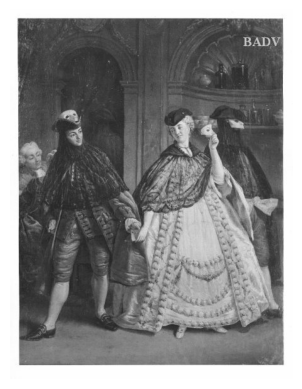

Rank 39: Munich image '0839_5329_id=cp168359_badv.jpg' (Similarity: 0.5072435140609741)


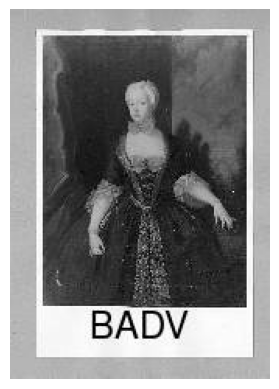

Rank 40: Munich image '0551_2621_id=cp151714_badv.jpg' (Similarity: 0.506848931312561)


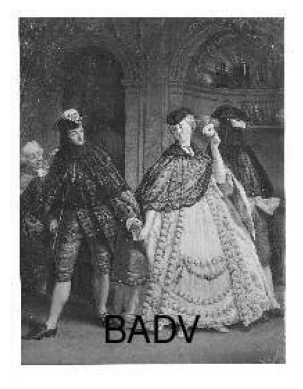

Rank 41: Munich image '0050_187-1_id=cp145819_badv.jpg' (Similarity: 0.5061347484588623)


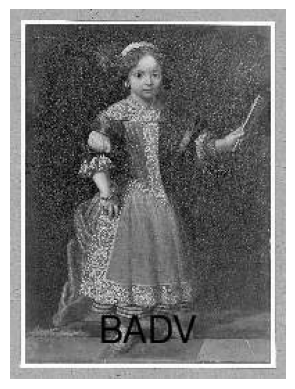

Rank 42: Munich image '1199_9164_id=cp134111_linz.jpg' (Similarity: 0.5055803060531616)


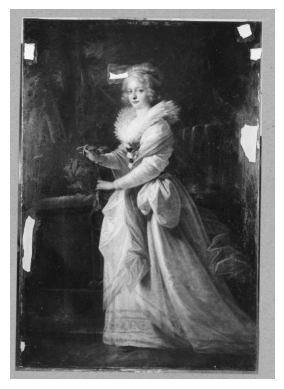

Rank 43: Munich image '0533_2447_id=cp131323_linz.jpg' (Similarity: 0.5040047764778137)


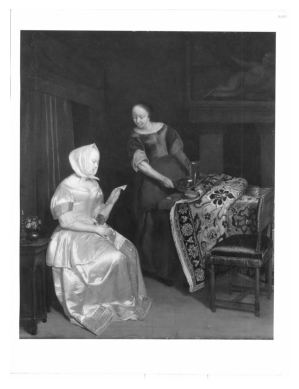

Rank 44: Munich image '0778_4839_id=cp133138_linz.jpg' (Similarity: 0.5020138025283813)


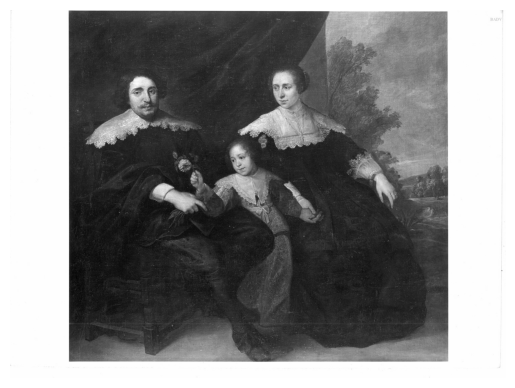

Rank 45: Munich image '1222_9397_id=cp176211_badv.jpg' (Similarity: 0.5002329349517822)


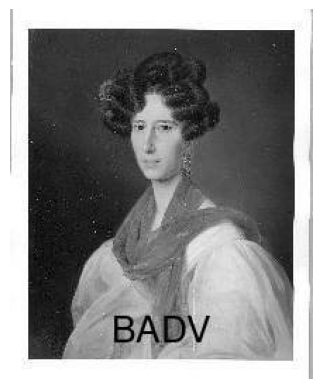

Rank 46: Munich image '2217_45070_id=cp132850_linz.jpg' (Similarity: 0.4976978898048401)


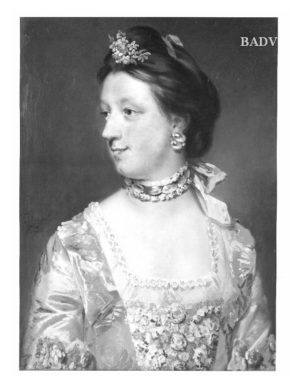

Rank 47: Munich image '1206_9230_id=cp175854_badv.jpg' (Similarity: 0.49715369939804077)


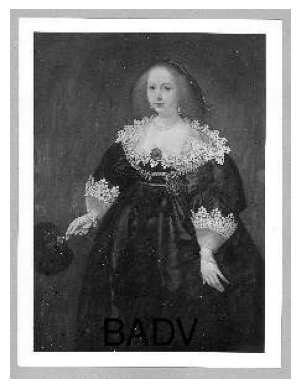

Rank 48: Munich image '0614_3075_id=cp154073_badv.jpg' (Similarity: 0.4957331120967865)


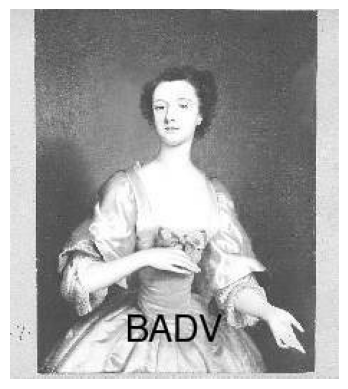

Rank 49: Munich image '0270_1455_id=cp131505_linz.jpg' (Similarity: 0.4953206479549408)


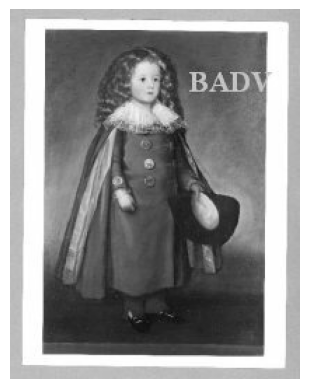

Rank 50: Munich image '1351_11194_id=cp136409_badv.jpg' (Similarity: 0.4950239360332489)


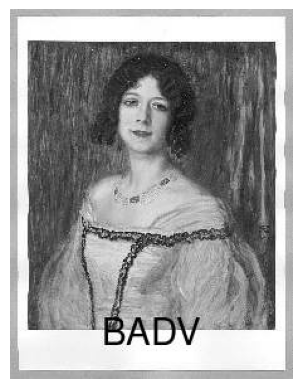

In [40]:
def rank_similarities(similarities):
    """
    Get a ranking of the highest similarity values for each NK image from the similarities dictionary.
    
    Parameters:
    - similarities: A dictionary where keys are (NK image name, Munich image name) tuples
                    and values are similarity scores.
                    
    Returns:
    - A dictionary where keys are NK image names and values are lists of tuples
      (Munich image name, similarity) sorted by similarity in descending order.
    """
    top_similarities = {}
    
    for nk_img_name in set(key[0] for key in similarities.keys()):
        # Filter similarities for current NK image
        nk_similarities = [(munich_img_name, similarity) for (nk, munich_img_name), similarity in similarities.items() if nk == nk_img_name]
        
        # Sort by similarity in descending order
        sorted_similarities = sorted(nk_similarities, key=lambda x: x[1], reverse=True)
        
        # Get top similarities
        top_similarities[nk_img_name] = sorted_similarities[:50]
    
    return top_similarities

def display_image(image_path):
    image = imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

def display_nk_image(nk_img_name):
    image_path = f"nk_collection_paintings/{nk_img_name}"
    image = imread(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()


top_sims = rank_similarities(sims)
rank = 1
for nk_img_name, similar_images in top_sims.items():
    print(f"Ranking of images similar to NK image '{nk_img_name}':")
    display_nk_image(nk_img_name)
    for munich_img_name, similarity in similar_images:
        image_path = f"scraped_images_grayscaled_big/{munich_img_name}"
        print(f"Rank {rank}: Munich image '{munich_img_name}' (Similarity: {similarity})")
        display_image(image_path)
        rank += 1
        
